<a href="https://colab.research.google.com/github/soyoungpark9187/DeepLearning/blob/master/DL_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Competition 201735831 박소영**

drive mount

In [ ]:
from google.colab import drive
  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import os
from skimage import io
from skimage.util import random_noise
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import cv2
import pandas as pd

In [ ]:
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        # download pretrained weight
        state_dict = load_state_dict_from_url(model_urls[arch],progress=progress)
        # assign to model
        model.load_state_dict(state_dict)
    return model

In [ ]:
def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

model

In [ ]:
from torchvision import models
import torch

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

model = models.resnet50(pretrained=True)

# last layer modification
#model.fc = nn.Linear(512,10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

train

In [ ]:
def train(model, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (image, target) in enumerate(train_loader):
    data, target = image.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 150 == 0 :
      print('Train Epoch : {} [{}/{} ({:.0f})%]\tLoss: {:.6f}'
      .format(epoch, batch_idx*len(image),len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item()))

def evaluate(model, test_loader):
  model.eval()
  test_loss =0
  correct =0
  with torch.no_grad():
    for (image, target) in test_loader:
      image, label = image.to(DEVICE), target.to(DEVICE)
      output = model(image)

      test_loss += F.cross_entropy(output, label, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1]
      correct+= pred.eq(label.view_as(pred)).sum().item()
  
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

data augmentation methods

In [ ]:
def augmentation(image):
    height, width, channel = image.shape
    # random rotation degree
    degree = np.random.randint(0,360)
    # color
    b = idx = np.random.randint(255)
    g = idx = np.random.randint(255)
    r = idx = np.random.randint(255)

    # pt1 #TODO: 범위
    y1 = np.random.randint(height/2)
    x1 = np.random.randint(width/2)

    # pt2
    y2 = np.random.randint(y1+50, y1+(height-y1)/2)
    x2 = np.random.randint(x1+50, x1+(width-x1)/2)

    matrix = cv2.getRotationMatrix2D((width/2, height/2), degree, 1)

    image = cv2.warpAffine(image, matrix, (width, height))

    image = cv2.rectangle(image, (y1, x1), (y2, x2), (b, g, r), -1)

    image = random_noise(image, mode='gaussian', mean=0, var=0.1)

    return image

In [ ]:
data_dir = "/content/drive/My Drive"
root = data_dir + '/swdl2020'

os.chdir("/content/drive/My Drive")
os.getcwd()

'/content/drive/My Drive'

test augmentation

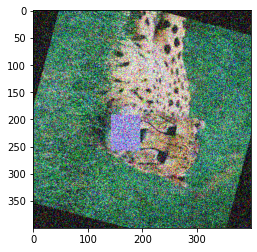

In [ ]:
image = plt.imread("./swdl2020/train/cheetah_train_resized"+"/cheetah_899_resized.jpg")

height, width, channel = image.shape
    # random rotation degree
degree = np.random.randint(0,360)
    # color
b = idx = np.random.randint(255)
g = idx = np.random.randint(255)
r = idx = np.random.randint(255)

    # pt1 #TODO: 범위
y1 = np.random.randint(height/2)
x1 = np.random.randint(width/2)

    # pt2
y2 = np.random.randint(y1+50, y1+(height-y1)/2)
x2 = np.random.randint(x1+50, x1+(width-x1)/2)

matrix = cv2.getRotationMatrix2D((width/2, height/2), degree, 1)

image = cv2.warpAffine(image, matrix, (width, height))

image = cv2.rectangle(image, (y1, x1), (y2, x2), (b, g, r), -1)

image = random_noise(image, mode='gaussian', mean=0, var=0.1)

plt.imshow(image)

data load

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
])
class MyDataset(Dataset):
  def __init__(self, image_dir, label, transforms=None):
    self.image_dir = image_dir
    self.label = label
    self.image_list = os.listdir(self.image_dir)
    self.transforms = transform
  
  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self,idx):
    # if torch.is_tensor(idx):
    #   idx = idx.tolist()

    image_name = os.path.join(self.image_dir, self.image_list[idx])
    image = io.imread(image_name)

    ### transform
    image = transform(image)

    # type casting
    image=image.type(torch.cuda.FloatTensor)
    return (image,self.label)
    
class MyDataset_a(Dataset):
  def __init__(self, image_dir, label, transforms=None):
    self.image_dir = image_dir
    self.label = label
    self.image_list = os.listdir(self.image_dir)
    self.transforms = transform
  
  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self,idx):
    # if torch.is_tensor(idx):
    #   idx = idx.tolist()

    image_name = os.path.join(self.image_dir, self.image_list[idx])
    image = io.imread(image_name)

    image = augmentation(image)

    ### transform
    image = transform(image)

    # type casting
    image=image.type(torch.cuda.FloatTensor)
    return (image,self.label)

#cheetah : 0 , jaguar : 1, tiger : 2, hyena : 3

# original train
cheetah_train = MyDataset("./swdl2020/train/cheetah_train_resized",0,transform)
jaguar_train = MyDataset("./swdl2020/train/jaguar_train_resized",1,transform)
tiger_train = MyDataset("./swdl2020/train/tiger_train_resized",2,transform)
hyena_train = MyDataset("./swdl2020/train/hyena_train_resized",3,transform)

#augment train
cheetah_train_a = MyDataset_a("./swdl2020/train/cheetah_train_resized",0,transform)
jaguar_train_a = MyDataset_a("./swdl2020/train/jaguar_train_resized",1,transform)
tiger_train_a = MyDataset_a("./swdl2020/train/tiger_train_resized",2,transform)
hyena_train_a = MyDataset_a("./swdl2020/train/hyena_train_resized",3,transform)

train_set = ConcatDataset([cheetah_train, jaguar_train, tiger_train, hyena_train,
                           cheetah_train_a, jaguar_train_a, tiger_train_a, hyena_train_a])
print("Number of Training set images : ", len(train_set))

#original val
cheetah_val = MyDataset_a("./swdl2020/validation/cheetah_validation_resized",0, transform)
jaguar_val = MyDataset_a("./swdl2020/validation/jaguar_validation_resized",1, transform)
tiger_val = MyDataset_a("./swdl2020/validation/tiger_validation_resized",2, transform)
hyena_val = MyDataset_a("./swdl2020/validation/hyena_validation_resized",3,transform)

val_set = ConcatDataset([cheetah_val, jaguar_val, tiger_val, hyena_val])
print("Numver of Validation set images : ", len(val_set))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

Number of Training set images :  7200
Numver of Validation set images :  400


execute

In [ ]:
import torch.optim as optim
learnning_rate = 0.01
EPOCH = 10

optimizer = optim.Adadelta(model.parameters(), lr=learnning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

for epoch in range(1, EPOCH+1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, val_loader)
    print('[{}] Test Loss : {:.4f}, Accuracy : {:.4f}%'.format(epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/7200 (0)%]	Loss: 1.448907


KeyboardInterrupt: ignored

test loader

In [ ]:
class TestDataset(Dataset):
  def __init__(self, image_dir, transforms=None):
    self.image_dir = image_dir
    self.image_list = os.listdir(self.image_dir)
    self.transforms = transforms
  
  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self,idx):
    # if torch.is_tensor(idx):
    #   idx = idx.tolist()

    image_name = os.path.join(self.image_dir, self.image_list[idx])
    image = io.imread(image_name)

    ### transform
    image = transform(image)

    return (image,self.image_list[idx].split('.')[0])


test_set = TestDataset("./swdl2020/test100", transforms)
test_loader = DataLoader(test_set)

prediction

In [ ]:
#cheetah : 0 , jaguar : 1, tiger : 2, hyena : 3
map = ['cheetah','jaguar','tiger','hyena']

model.eval()
df = pd.DataFrame(columns=['id','category'])
with torch.no_grad():
    for (image, image_name) in test_loader:
        # type casting
        image = image.type(torch.cuda.FloatTensor)
        output = model(image)
        pred = output.max(1, keepdim=True)[1]
        df = df.append(pd.DataFrame([[image_name[0], map[pred.squeeze().tolist()]]], columns=['id','category']))
df

label counting

In [ ]:
print('tiger', len(df[df['category']=='tiger']))
print('cheetah', len(df[df['category']=='cheetah']))
print('jaguar', len(df[df['category']=='jaguar']))
print('hyena', len(df[df['category']=='hyena']))

save csv file

In [ ]:
df.to_csv('./swdl2020/res.csv'+'20200625_ori+aug.csv', index=False)
print(df.columns)
df.head()

In [ ]:
# compare
answer = pd.read_excel("./swdl2020/label.xlsx")
answer.head()

In [ ]:
arr1  = df.values
arr2 = answer.values

In [ ]:
# label counting (answer)
print('tiger', len(answer[answer['jaguar']=='tiger']))
print('cheetah', len(answer[answer['jaguar']=='cheetah']))
print('jaguar', len(answer[answer['jaguar']=='jaguar']))
print('hyena', len(answer[answer['jaguar']=='hyena']))

In [ ]:
sum=0
for i in range(99):
  for j in range(99):
    if int(arr1[i+1][0]) == arr2[j][0]:
      if arr1[i+1][1] == arr2[j][1]:
        sum+=1

print(sum)